# EDA & Clustering Pipeline — Bus Trips (Price + Ratings)

This notebook performs a clean end-to-end pipeline:
1. Load data
2. Feature engineering (price & ratings)
3. Scaling with RobustScaler
4. PCA for structure inspection
5. KMeans clustering with Silhouette analysis
6. (Optional) Gaussian Mixture Model (GMM) clustering
7. Cluster profiling (interpretation)


In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


## 1. Load data

In [2]:

folder_path = "../data/processed"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))


lst_df = []
for file in csv_files:
    df = pd.read_csv(file)
    lst_df.append(df)
df = pd.concat(lst_df)
df = df.reset_index(drop=True)

In [3]:
print("Shape:", df.shape)
df.head()

Shape: (25972, 21)


,company_name,departure_time,pickup_point,arrival_time,dropoff_point,price_original,price_discounted,departure_date,start_point,destination,...,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes
0,Hoàng Thuỷ,18:45:00,Bến xe,05:45,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.7,4.7,4.6,4.6,4.9,4.7,3485,34,660
1,Sinh Diên Hồng,17:30:00,Bến xe,04:15,Bến xe,370000,296000,2025-11-12,Sài Gòn,Gia Lai,...,4.7,4.8,4.8,4.6,4.6,4.9,4.6,237,34,645
2,Phong Phú,20:00:00,Văn phòng,07:45,Văn phòng,530000,399000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.4,4.4,4.7,4.5,8677,24,705
3,Kính Diên Hồng,18:40:00,Bến xe,05:40,Bến xe,350000,0,2025-11-12,Sài Gòn,Gia Lai,...,4.6,4.7,4.6,4.5,4.5,4.5,4.6,1135,34,660
4,Đức Đạt,20:10:00,Bến xe,06:35,Bến xe,350000,300000,2025-11-12,Sài Gòn,Gia Lai,...,4.5,4.6,4.5,4.5,4.5,4.9,4.7,1027,34,625


In [4]:
# Quick info & numeric summary
display(df.info())
display(df.describe(include="number").T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25972 entries, 0 to 25971
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_name              25972 non-null  object 
 1   departure_time            25972 non-null  object 
 2   pickup_point              25972 non-null  object 
 3   arrival_time              25972 non-null  object 
 4   dropoff_point             25972 non-null  object 
 5   price_original            25972 non-null  int64  
 6   price_discounted          25972 non-null  int64  
 7   departure_date            25972 non-null  object 
 8   start_point               25972 non-null  object 
 9   destination               25972 non-null  object 
 10  rating_safety             25972 non-null  float64
 11  rating_info_accuracy      25972 non-null  float64
 12  rating_info_completeness  25972 non-null  float64
 13  rating_staff_attitude     25972 non-null  float64
 14  rating

None

,count,mean,std,min,25%,50%,75%,max
price_original,25972.0,332585.977206,158508.381399,0.0,220000.0,300000.0,405000.0,1200000.0
price_discounted,25972.0,132753.074580,172687.028323,0.0,0.0,0.0,270000.0,900000.0
rating_safety,25972.0,4.585419,0.362006,2.3,4.5,4.7,4.8,5.0
rating_info_accuracy,25972.0,4.451444,0.468520,1.0,4.2,4.6,4.8,5.0
rating_info_completeness,25972.0,4.510461,0.423032,1.0,4.3,4.6,4.8,5.0
rating_staff_attitude,25972.0,4.486809,0.428520,1.0,4.3,4.6,4.8,5.0
rating_comfort,25972.0,4.436458,0.463350,1.0,4.2,4.6,4.7,5.0
rating_service_quality,25972.0,4.402753,0.477228,1.0,4.2,4.5,4.7,5.0
rating_punctuality,25972.0,4.612059,0.466822,1.0,4.6,4.7,4.8,5.0
rating_overall,25972.0,4.426090,0.489739,0.0,4.2,4.6,4.8,5.0


In [5]:
df.columns

Index(['company_name', 'departure_time', 'pickup_point', 'arrival_time',
       'dropoff_point', 'price_original', 'price_discounted', 'departure_date',
       'start_point', 'destination', 'rating_safety', 'rating_info_accuracy',
       'rating_info_completeness', 'rating_staff_attitude', 'rating_comfort',
       'rating_service_quality', 'rating_punctuality', 'rating_overall',
       'reviewer_count', 'number_of_seat', 'duration_minutes'],
      dtype='object')

In [6]:
useless_columns = ['company_name', 'departure_date', 'arrival_time', 'departure_time', 'arrival_time', \
                   'pickup_point', 'dropoff_point', 'start_point', 'destination']

df = df.drop(columns=useless_columns)
df

,price_original,price_discounted,rating_safety,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes
0,350000,300000,4.8,4.7,4.7,4.7,4.6,4.6,4.9,4.7,3485,34,660
1,370000,296000,4.7,4.7,4.8,4.8,4.6,4.6,4.9,4.6,237,34,645
2,530000,399000,4.5,4.5,4.6,4.5,4.4,4.4,4.7,4.5,8677,24,705
3,350000,0,4.7,4.6,4.7,4.6,4.5,4.5,4.5,4.6,1135,34,660
4,350000,300000,4.6,4.5,4.6,4.5,4.5,4.5,4.9,4.7,1027,34,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25967,589000,330000,4.1,3.9,4.1,4.0,4.0,3.8,4.2,3.8,2872,21,630
25968,450000,0,4.1,3.9,4.0,4.0,3.9,3.8,4.3,3.8,2390,22,630
25969,450000,0,4.1,3.9,4.0,4.0,3.9,3.8,4.3,3.8,2390,22,485
25970,450000,0,4.1,3.9,4.0,4.0,3.9,3.8,4.3,3.8,2390,22,480


In [7]:
df[df['duration_minutes'] == 0]

,price_original,price_discounted,rating_safety,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,reviewer_count,number_of_seat,duration_minutes


---

## 2. Feature Engineering

In [8]:
def handle_price_discounted(df,):
    df.loc[df['price_discounted'] == 0, 'price_discounted'] = df['price_original']
    return df


def add_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add discount_rate and price_per_minute.
    """
    # Phần trăm giảm giá
    df["discount_rate"] = (df["price_original"] - df["price_discounted"]) / df["price_original"].replace(0, np.nan)
    df["discount_rate"] = df["discount_rate"].fillna(0)
    
    # Avoid division by zero for duration
    df["price_per_minute"] = df["price_discounted"] / df["duration_minutes"]
    df["price_per_minute"] = df["price_per_minute"].fillna(0)
    return df


def add_rating_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Kết hợp các thuộc tính đánh giá thành các chỉ số tổng hợp
    """
    quality_cols = [
        "rating_comfort",
        "rating_service_quality",
        "rating_staff_attitude",
    ]
    info_cols = [
        "rating_info_accuracy",
        "rating_info_completeness",
    ]
    
    df["rating_quality"] = df[quality_cols].mean(axis=1)
    df["rating_info"] = df[info_cols].mean(axis=1)
    
    # Value for money: overall rating per unit price
    df["value_index"] = df["rating_overall"] / (df["price_original"]/1000).replace(0, np.nan)
    df["value_index"] = df["value_index"].fillna(0)
    
    return df

def add_interaction_features(df):

    df['price_rating_interaction'] = df['price_original'] * df['rating_overall']
    
    # Tương tác giữa discount và rating
    df['discount_rating_interaction'] = df['discount_rate'] * df['rating_overall']
    
    # Tương tác giữa số reviewer và rating
    df['reviewer_rating_interaction'] = df['reviewer_count'] * df['rating_overall']
    df['reviewer_weight'] = np.log1p(df['reviewer_count']) * df['rating_overall']
    
    return df


def add_time_distance_features(df):
    # Tính giờ xuất phát trong ngày (sáng/chiều/tối/đêm)
    df['time_of_day'] = pd.cut(df['departure_time_hour'], 
                                bins=[0, 6, 12, 18, 24],
                                labels=['night', 'morning', 'afternoon', 'evening'])
    df['time_of_day_encoded'] = df['time_of_day'].cat.codes
    
    # Tính thời gian di chuyển trên giá
    df['price_per_hour'] = df['price_discounted'] / (df['duration_minutes'] / 60 + 0.0001)
    
    # Tính tốc độ trung bình (nếu có thông tin khoảng cách)
    # df['avg_speed'] = df['distance'] / (df['duration_minutes'] / 60)
    
    return df


def add_rating_analysis_features(df):
    # Độ lệch chuẩn của các rating
    rating_cols = ['rating_safety', 'rating_info', 'rating_quality', 
                   'rating_punctuality', 'rating_overall']
    df['rating_std'] = df[rating_cols].std(axis=1)
    
    # Rating gap (chênh lệch giữa rating cao nhất và thấp nhất)
    df['rating_gap'] = df[rating_cols].max(axis=1) - df[rating_cols].min(axis=1)
    
    # Consistency score (càng gần 0 càng nhất quán)
    df['rating_consistency'] = 1 / (df['rating_std'] + 0.0001)
    
    # Weighted rating (trọng số dựa trên số reviewer)
    df['weighted_rating'] = (df['rating_overall'] * np.log1p(df['reviewer_count'])) / \
                           (np.log1p(df['reviewer_count']) + 1)
    
    return df


def add_categorical_features(df):
    # Phân loại giá
    df['price_category'] = pd.cut(df['price_discounted'],
                                   bins=[0, 200000, 300000, 400000, np.inf],
                                   labels=['budget', 'economy', 'standard', 'premium'])
    df['price_category_encoded'] = df['price_category'].cat.codes
    
    # Phân loại rating
    df['rating_category'] = pd.cut(df['rating_overall'],
                                    bins=[0, 3.5, 4.0, 4.5, 5.0],
                                    labels=['low', 'medium', 'high', 'excellent'])
    df['rating_category_encoded'] = df['rating_category'].cat.codes
    
    # Phân loại số reviewer
    df['reviewer_category'] = pd.qcut(df['reviewer_count'], 
                                       q=4, 
                                       labels=['few', 'some', 'many', 'lots'],
                                       duplicates='drop')
    df['reviewer_category_encoded'] = df['reviewer_category'].cat.codes
    
    return df

def add_price_seats(df):
    df['price_seat_ratio'] = df['price_original'] / df['number_of_seat']

In [9]:
def add_comparison_features(df):
    # So sánh với giá trung bình của route
    df['price_vs_route_avg'] = df.groupby(['start_point', 'destination'])['price_discounted'].transform(
        lambda x: (x - x.mean()) / (x.std() + 0.0001)
    )
    
    # So sánh với rating trung bình của company
    df['rating_vs_company_avg'] = df.groupby('company_name')['rating_overall'].transform(
        lambda x: (x - x.mean()) / (x.std() + 0.0001)
    )
    
    return df

In [10]:
handle_price_discounted(df)
add_price_features(df)
add_rating_features(df)
add_interaction_features(df)
add_price_seats(df)

In [11]:
df.head()

,price_original,price_discounted,rating_safety,rating_info_accuracy,rating_info_completeness,rating_staff_attitude,rating_comfort,rating_service_quality,rating_punctuality,rating_overall,...,discount_rate,price_per_minute,rating_quality,rating_info,value_index,price_rating_interaction,discount_rating_interaction,reviewer_rating_interaction,reviewer_weight,price_seat_ratio
0,350000,300000,4.8,4.7,4.7,4.7,4.6,4.6,4.9,4.7,...,0.142857,454.545455,4.633333,4.70,0.013429,1645000.0,0.671429,16379.5,38.335598,10294.117647
1,370000,296000,4.7,4.7,4.8,4.8,4.6,4.6,4.9,4.6,...,0.200000,458.914729,4.666667,4.75,0.012432,1702000.0,0.920000,1090.2,25.172445,10882.352941
2,530000,399000,4.5,4.5,4.6,4.5,4.4,4.4,4.7,4.5,...,0.247170,565.957447,4.433333,4.55,0.008491,2385000.0,1.112264,39046.5,40.808459,22083.333333
3,350000,350000,4.7,4.6,4.7,4.6,4.5,4.5,4.5,4.6,...,0.000000,530.303030,4.533333,4.65,0.013143,1610000.0,0.000000,5221.0,32.362236,10294.117647
4,350000,300000,4.6,4.5,4.6,4.5,4.5,4.5,4.9,4.7,...,0.142857,480.000000,4.500000,4.55,0.013429,1645000.0,0.671429,4826.9,32.596241,10294.117647


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price_original,25972.0,3.325860e+05,158508.381399,0.00,220000.000000,3.000000e+05,4.050000e+05,1.200000e+06
price_discounted,25972.0,3.085147e+05,148065.589776,0.00,210000.000000,2.900000e+05,3.800000e+05,1.200000e+06
rating_safety,25972.0,4.585419e+00,0.362006,2.30,4.500000,4.700000e+00,4.800000e+00,5.000000e+00
rating_info_accuracy,25972.0,4.451444e+00,0.468520,1.00,4.200000,4.600000e+00,4.800000e+00,5.000000e+00
rating_info_completeness,25972.0,4.510461e+00,0.423032,1.00,4.300000,4.600000e+00,4.800000e+00,5.000000e+00
rating_staff_attitude,25972.0,4.486809e+00,0.428520,1.00,4.300000,4.600000e+00,4.800000e+00,5.000000e+00
rating_comfort,25972.0,4.436458e+00,0.463350,1.00,4.200000,4.600000e+00,4.700000e+00,5.000000e+00
rating_service_quality,25972.0,4.402753e+00,0.477228,1.00,4.200000,4.500000e+00,4.700000e+00,5.000000e+00
rating_punctuality,25972.0,4.612059e+00,0.466822,1.00,4.600000,4.700000e+00,4.800000e+00,5.000000e+00
rating_overall,25972.0,4.426090e+00,0.489739,0.00,4.200000,4.600000e+00,4.800000e+00,5.000000e+00


In [13]:
d

NameError: name 'd' is not defined

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(5083, 23)

In [ ]:
df.columns.to_list()

['price_original',
 'price_discounted',
 'rating_safety',
 'rating_info_accuracy',
 'rating_info_completeness',
 'rating_staff_attitude',
 'rating_comfort',
 'rating_service_quality',
 'rating_punctuality',
 'rating_overall',
 'reviewer_count',
 'number_of_seat',
 'duration_minutes',
 'discount_rate',
 'price_per_minute',
 'rating_quality',
 'rating_info',
 'value_index',
 'price_rating_interaction',
 'discount_rating_interaction',
 'reviewer_rating_interaction',
 'reviewer_weight',
 'price_seat_ratio']

In [ ]:
feature = [
 'price_original',
 'price_discounted',
 'rating_safety',
 'rating_punctuality',
 'rating_overall',
 'discount_rate',
 'price_per_minute',
 'rating_quality',
 'rating_info',
 'value_index',
 'price_rating_interaction',
 'discount_rating_interaction',
 'reviewer_rating_interaction',
 'reviewer_weight',
 'price_seat_ratio'
 ]    

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

def improved_clustering_pipeline(df):
    # Chọn features tốt hơn
    features = [
 'price_original',
 'price_discounted',
 'rating_safety',
 'rating_punctuality',
 'rating_overall',
 'discount_rate',
 'price_per_minute',
 'rating_quality',
 'rating_info',
 'value_index',
 'price_rating_interaction',
 'discount_rating_interaction',
 'reviewer_rating_interaction',
 'reviewer_weight',
 'price_seat_ratio'
 ]
    
    X = df[features].copy()
    X = X.fillna(X.median())
    X = X.replace(0, X.median())
    
    # Sử dụng StandardScaler thay vì RobustScaler nếu không có nhiều outliers
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, features

In [ ]:
df[feature].describe().T

,count,mean,std,min,25%,50%,75%,max
price_original,5083.0,3.767177e+05,156101.881155,0.00,2.700000e+05,3.500000e+05,4.500000e+05,1.200000e+06
price_discounted,5083.0,3.387227e+05,144341.769065,0.00,2.500000e+05,3.090000e+05,4.050000e+05,1.200000e+06
rating_safety,5083.0,4.548239e+00,0.329487,2.30,4.400000e+00,4.700000e+00,4.800000e+00,5.000000e+00
rating_punctuality,5083.0,4.597187e+00,0.431874,1.00,4.500000e+00,4.700000e+00,4.800000e+00,5.000000e+00
rating_overall,5083.0,4.382805e+00,0.468596,0.00,4.200000e+00,4.500000e+00,4.700000e+00,5.000000e+00
discount_rate,5083.0,8.979806e-02,0.124104,0.00,0.000000e+00,3.125000e-02,1.428571e-01,7.272727e-01
price_per_minute,5083.0,9.147531e+02,700.382149,0.00,5.666667e+02,7.500000e+02,1.060606e+03,1.428571e+04
rating_quality,5083.0,4.384550e+00,0.418933,1.00,4.200000e+00,4.500000e+00,4.700000e+00,5.000000e+00
rating_info,5083.0,4.440252e+00,0.401115,2.35,4.250000e+00,4.550000e+00,4.700000e+00,5.000000e+00
value_index,5083.0,1.371804e-02,0.006781,0.00,9.600000e-03,1.236842e-02,1.623118e-02,7.142857e-02


## Outlier Overview (IQR-based)

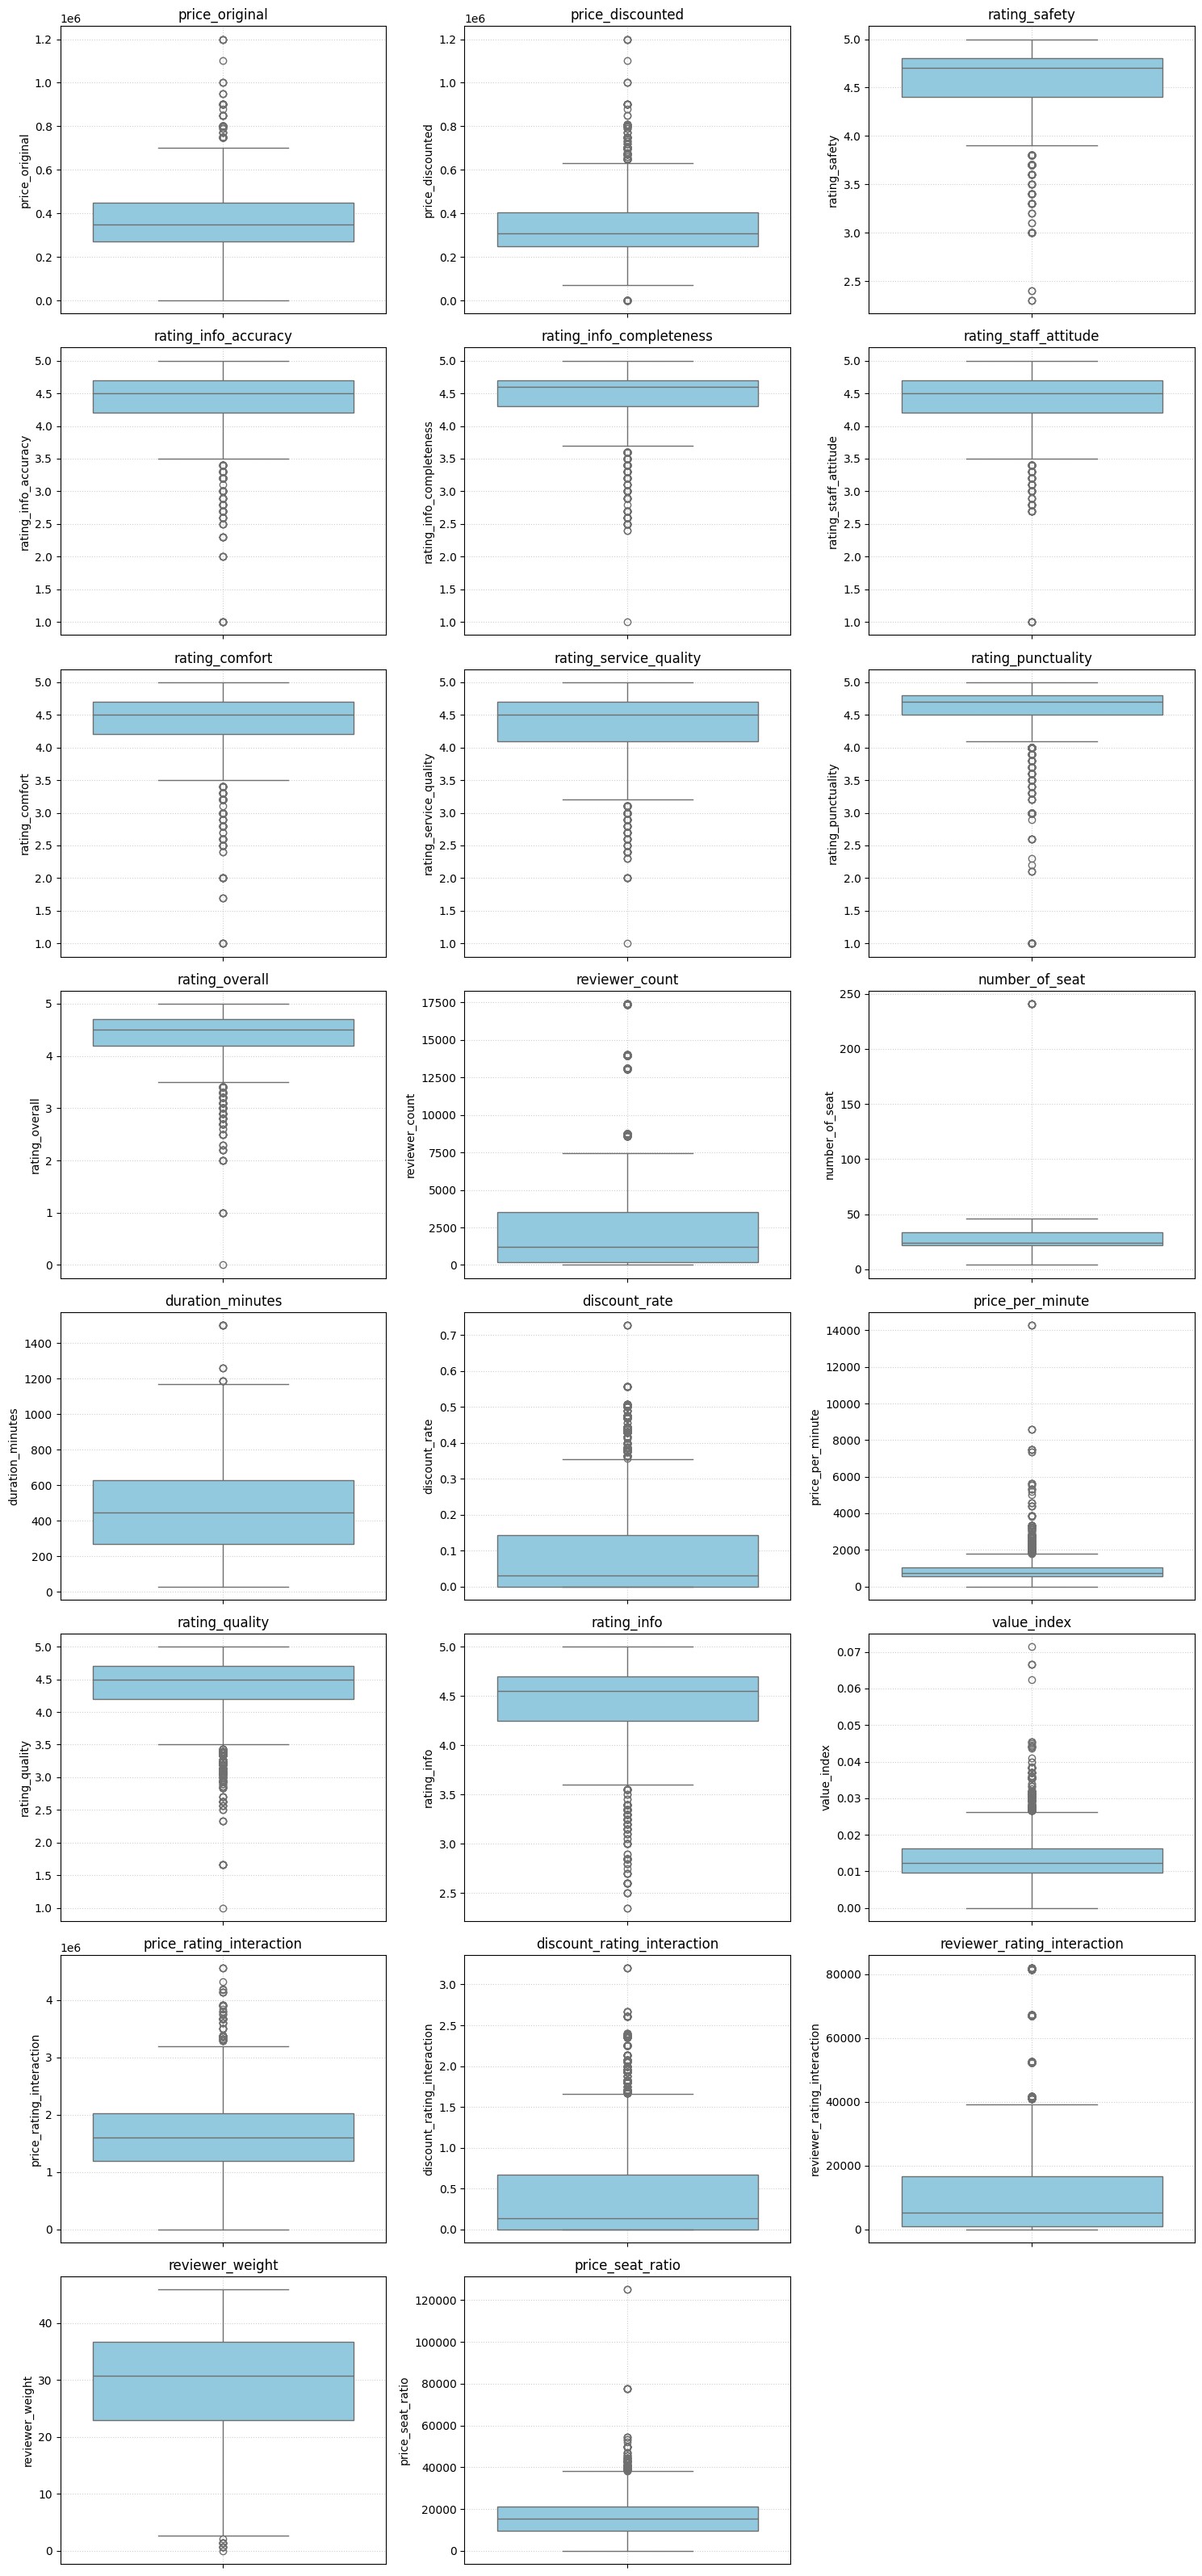

In [ ]:
# Boxplots for all numeric columns in df
num_cols = df.select_dtypes(include='number').columns.tolist()
n = len(num_cols)
if n == 0:
    print("No numeric columns found in df.")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.boxplot(y=df[col], ax=ax, color="skyblue")
        ax.set_title(col)
        ax.grid(True, linestyle=':', alpha=0.6)
    # hide any leftover axes
    for ax in axes[n:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
def iqr_outlier_ratio(series: pd.Series, k: float = 1.5) -> float:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    mask = (series < lower) | (series > upper)
    return mask.mean()

from scipy import stats

def remove_outliers(df, columns, z_threshold=3):
    df_clean = df.copy()
    for col in columns:
        z_scores = np.abs(stats.zscore(df_clean[col]))
        df_clean = df_clean[z_scores < z_threshold]
    return df_clean

# Hoặc clip outliers thay vì remove
def clip_outliers(df, columns, percentile=99):
    df_clipped = df.copy()
    for col in columns:
        upper = df_clipped[col].quantile(percentile/100)
        lower = df_clipped[col].quantile(1 - percentile/100)
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

num_cols = [feature]

outlier_stats = []
for col in num_cols:
    ratio = iqr_outlier_ratio(df[col].dropna())
    outlier_stats.append({"column": col, "outlier_ratio": ratio})

for data in outlier_stats:
    print(f"{data}")

{'column': ['price_original', 'price_discounted', 'rating_safety', 'rating_punctuality', 'rating_overall', 'discount_rate', 'price_per_minute', 'rating_quality', 'rating_info', 'value_index', 'price_rating_interaction', 'discount_rating_interaction', 'reviewer_rating_interaction', 'reviewer_weight', 'price_seat_ratio'], 'outlier_ratio': price_original                 0.024985
price_discounted               0.054692
rating_safety                  0.039544
rating_punctuality             0.073775
rating_overall                 0.045642
discount_rate                  0.062365
price_per_minute               0.052922
rating_quality                 0.033051
rating_info                    0.039347
value_index                    0.054299
price_rating_interaction       0.015542
discount_rating_interaction    0.055676
reviewer_rating_interaction    0.076333
reviewer_weight                0.002558
price_seat_ratio               0.022428
dtype: float64}


In [ ]:
for col in num_cols:
    df = remove_outliers(df[col], col)

In [ ]:
outlier_stats = []
for col in num_cols:
    ratio = iqr_outlier_ratio(df[col].dropna())
    outlier_stats.append({"column": col, "outlier_ratio": ratio})

for data in outlier_stats:
    print(f"{data}")

{'column': ['price_original', 'price_discounted', 'rating_safety', 'rating_punctuality', 'rating_overall', 'discount_rate', 'price_per_minute', 'rating_quality', 'rating_info', 'value_index', 'price_rating_interaction', 'discount_rating_interaction', 'reviewer_rating_interaction', 'reviewer_weight', 'price_seat_ratio'], 'outlier_ratio': price_original                 0.005735
price_discounted               0.032258
rating_safety                  0.010036
rating_punctuality             0.045161
rating_overall                 0.005257
discount_rate                  0.027479
price_per_minute               0.042294
rating_quality                 0.000000
rating_info                    0.000000
value_index                    0.038232
price_rating_interaction       0.009080
discount_rating_interaction    0.021266
reviewer_rating_interaction    0.054002
reviewer_weight                0.002389
price_seat_ratio               0.011470
dtype: float64}


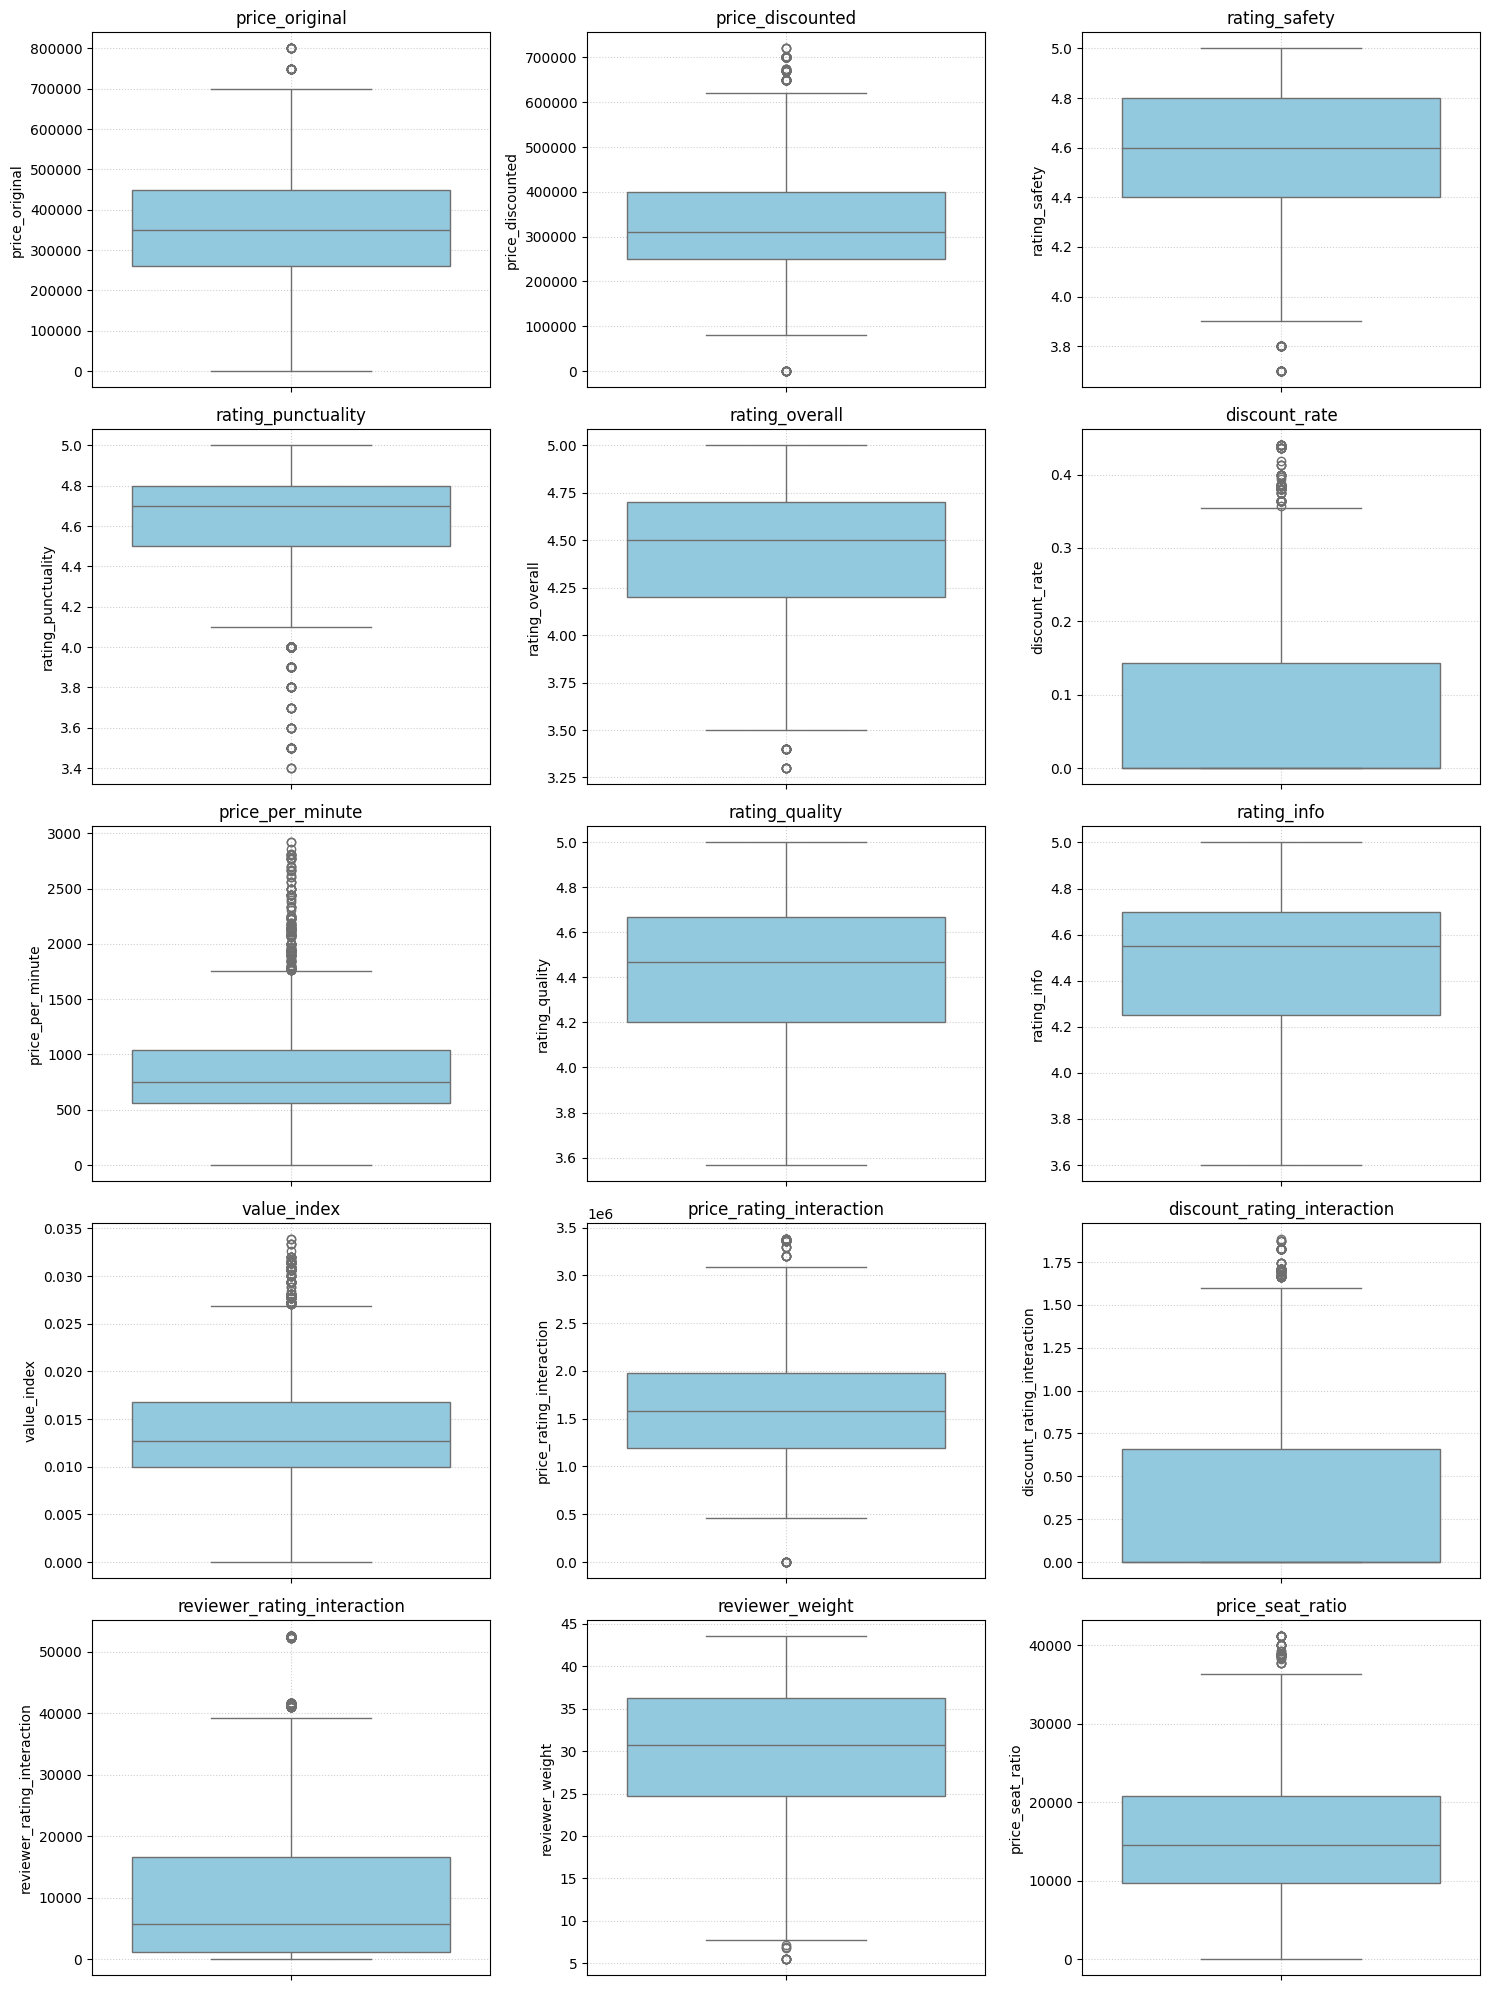

In [ ]:
# Boxplots for all numeric columns in df
num_cols = df.select_dtypes(include='number').columns.tolist()
n = len(num_cols)
if n == 0:
    print("No numeric columns found in df.")
else:
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.boxplot(y=df[col], ax=ax, color="skyblue")
        ax.set_title(col)
        ax.grid(True, linestyle=':', alpha=0.6)
    # hide any leftover axes
    for ax in axes[n:]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
X_scaled = improved_clustering_pipeline(df)[0]

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hc = hc.fit_predict(X_scaled)

# So sánh các metrics
print(f"Silhouette (DBSCAN): {silhouette_score(X_scaled, labels_dbscan):.4f}")
print(f"Davies-Bouldin (DBSCAN): {davies_bouldin_score(X_scaled, labels_dbscan):.4f}")

Silhouette (DBSCAN): 0.3083
Davies-Bouldin (DBSCAN): 1.2556


## Prepare Data for Clustering

## PCA: Inspect Structure

Explained variance (2 components): 0.5732820980161474


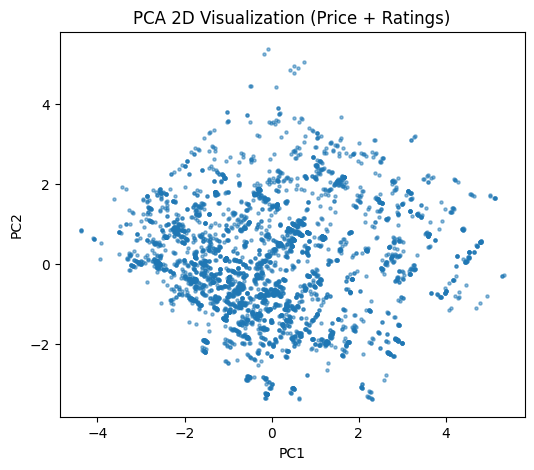

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance (2 components):", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D Visualization (Price + Ratings)")
plt.show()

## KMeans: Silhouette Analysis

In [ ]:
results_kmeans = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    results_kmeans.append((k, score))

for k, score in results_kmeans:
    print(f"Number of clusters: {k}, Silhouette Score: {score:.4f}")

best_k, best_score = max(results_kmeans, key=lambda x: x[1])
print("\nBest KMeans k:", best_k, "with Silhouette:", round(best_score, 4))

Number of clusters: 2, Silhouette Score: 0.2220
Number of clusters: 3, Silhouette Score: 0.1910
Number of clusters: 4, Silhouette Score: 0.1970
Number of clusters: 5, Silhouette Score: 0.1936
Number of clusters: 6, Silhouette Score: 0.1725
Number of clusters: 7, Silhouette Score: 0.1879
Number of clusters: 8, Silhouette Score: 0.1881

Best KMeans k: 2 with Silhouette: 0.222


In [ ]:
import umap
print(umap.__file__)


f:\Document\Tổng hợp các môn học\Đồ án DS\.venv\lib\site-packages\umap\__init__.py


In [ ]:
import umap
print(umap.__version__)

AttributeError: module 'umap' has no attribute '__version__'

In [ ]:
from umap.umap_ import UMAP

umap_model = UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=30,
    min_dist=0.1
)

X_umap = umap_model.fit_transform(X_scaled)


TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'

In [ ]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

umap_model = UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=30,
    min_dist=0.1
)

X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_umap[:,0], X_umap[:,1], s=5, alpha=0.5)
plt.title("UMAP Visualization (Price + Ratings)")
plt.show()


TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'

In [ ]:
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

# UMAP (thường tốt hơn PCA cho clustering)
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print(X_tsne.sum())

TypeError: check_array() got an unexpected keyword argument 'ensure_all_finite'

In [ ]:
tsne.kl_divergence_


0.47338810563087463

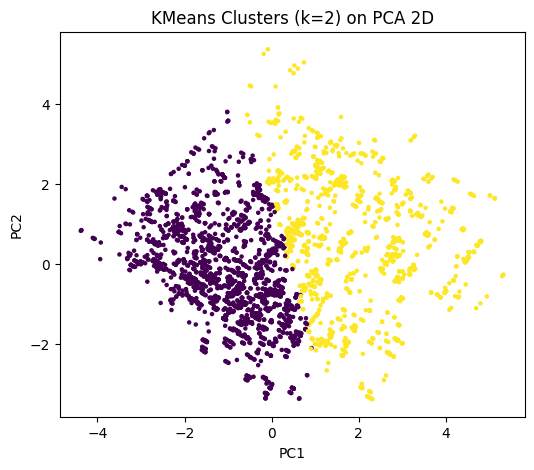

KeyError: "Columns not found: 'reviewer_count'"

In [ ]:
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster_kmeans"] = best_kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster_kmeans"], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) on PCA 2D")
plt.show()

df.groupby("cluster_kmeans")[features].mean().round(2)

## Gaussian Mixture Model (GMM): Silhouette Analysis

In [ ]:
results_gmm = []

for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    results_gmm.append((k, score))

for k, score in results_gmm:
    print(f"GMM components: {k}, Silhouette Score: {score:.4f}")

best_gmm_k, best_gmm_score = max(results_gmm, key=lambda x: x[1])
print("\nBest GMM components:", best_gmm_k, "with Silhouette:", round(best_gmm_score, 4))

GMM components: 2, Silhouette Score: 0.2274
GMM components: 3, Silhouette Score: 0.0660
GMM components: 4, Silhouette Score: 0.1247
GMM components: 5, Silhouette Score: 0.0545
GMM components: 6, Silhouette Score: 0.0818
GMM components: 7, Silhouette Score: 0.0492
GMM components: 8, Silhouette Score: 0.0671

Best GMM components: 2 with Silhouette: 0.2274


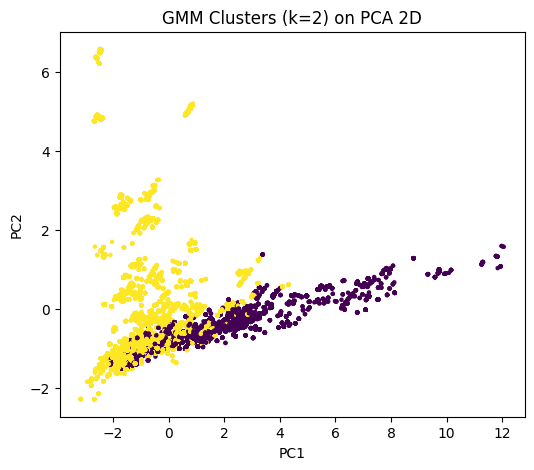

,price_discounted,discount_rate,price_per_minute,value_index,rating_overall,rating_quality,rating_info,rating_safety,rating_punctuality,reviewer_count
cluster_gmm,,,,,,,,,,
0,366298.49,0.85,134.58,0.0,3.96,4.03,4.05,4.26,4.29,214.61
1,288435.03,0.52,560.56,0.0,4.59,4.59,4.63,4.70,4.73,2743.63


In [ ]:
best_gmm = GaussianMixture(n_components=best_gmm_k, random_state=42)
df["cluster_gmm"] = best_gmm.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster_gmm"], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"GMM Clusters (k={best_gmm_k}) on PCA 2D")
plt.show()

df.groupby("cluster_gmm")[features].mean().round(2)

In [ ]:
df.groupby("cluster_kmeans")[[
    "price_discounted",
    "discount_rate",
    "price_per_minute",
    "value_index",

    "rating_overall",
    "rating_quality",
    "rating_info",
    "rating_safety",
    "rating_punctuality",

    "reviewer_count",
]].mean().round(2)


,price_discounted,discount_rate,price_per_minute,value_index,rating_overall,rating_quality,rating_info,rating_safety,rating_punctuality,reviewer_count
cluster_kmeans,,,,,,,,,,
0,413295.95,0.73,247.69,0.0,3.67,3.74,3.78,4.02,4.03,452.93
1,285125.59,0.58,493.45,0.0,4.60,4.60,4.64,4.71,4.75,2444.91
